In [37]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
def load_data(folder, img_size=(64, 64)):
    imgs = []
    labels = []

    for cl in os.listdir(folder):
        class_path = os.path.join(folder, cl)
        print("load " + class_path)
        for img_name in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_name))
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = img / 255.0
            imgs.append(img)
            labels.append(1 if cl == "wildfire" else 0)

    return np.array(imgs), np.array(labels)

In [7]:
dataset = "dataset"
train_path = os.path.join(dataset, "train")
valid_path = os.path.join(dataset, "valid")
test_path = os.path.join(dataset, "test")


train_img, train_labels = load_data(train_path)
valid_img, valid_labels = load_data(valid_path)
test_img, test_labels = load_data(test_path)

load dataset\train\nowildfire
load dataset\train\wildfire
load dataset\valid\nowildfire
load dataset\valid\wildfire
load dataset\test\nowildfire
load dataset\test\wildfire


In [11]:
train_cat = to_categorical(train_labels)
valid_cat = to_categorical(valid_labels)
test_cat = to_categorical(test_labels)

train_img, train_cat = shuffle(train_img, train_cat)


In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

batch_size = 32
steps_per_epoch = len(train_img) // batch_size

train_generator = train_datagen.flow(
    train_img, train_cat,
    batch_size=batch_size,
    shuffle=True
)

Training: 30250 Bilder
Validierung: 6300 Bilder
Test: 6300 Bilder


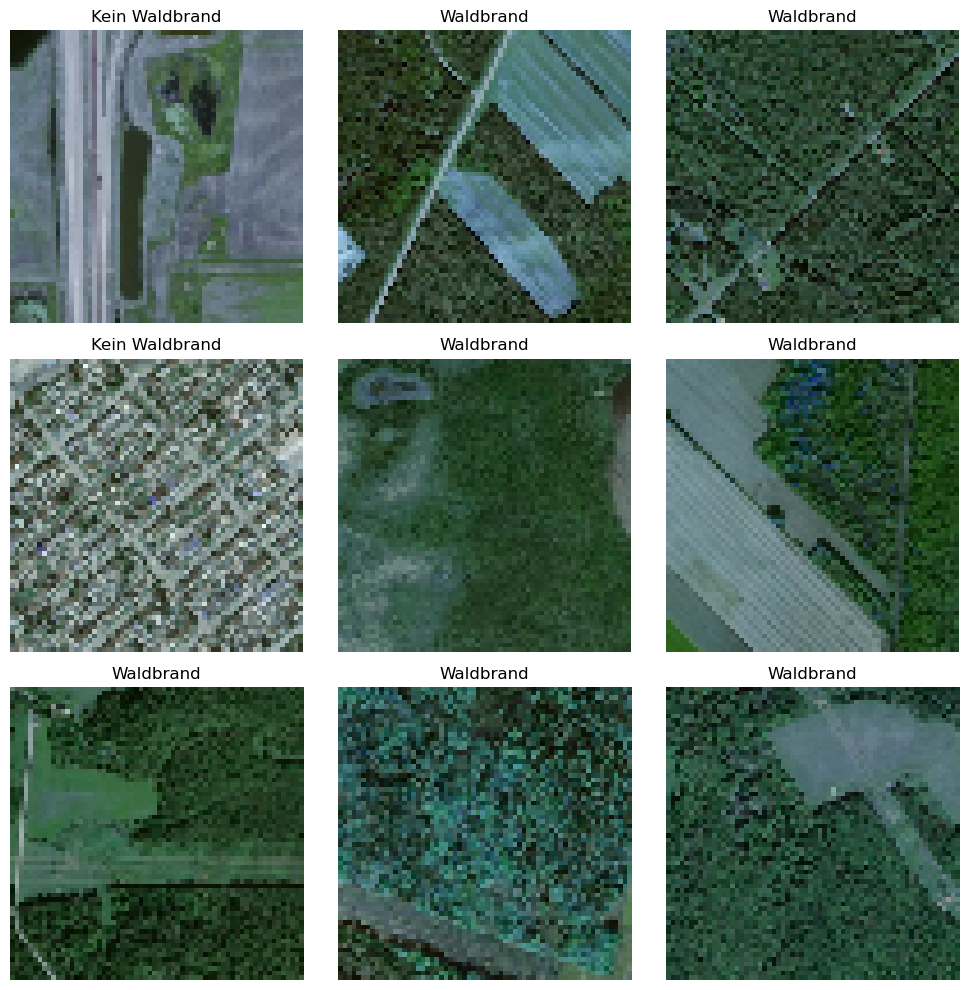

In [15]:
print(f"Training: {len(train_img)} Bilder")
print(f"Validierung: {len(valid_img)} Bilder")
print(f"Test: {len(test_img)} Bilder")

def zeige_batch(bilder, labels, anzahl=9):
    plt.figure(figsize=(10, 10))
    for i in range(min(anzahl, len(bilder))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(bilder[i])
        if isinstance(labels[i], np.ndarray) and len(labels[i]) > 1:
            label = np.argmax(labels[i])
        else:
            label = labels[i]

        plt.title('Waldbrand' if label == 1 else 'Kein Waldbrand')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

zeige_batch(train_img, train_cat)
image_batch, label_batch = next(train_generator)

In [19]:
img_height, img_width = 64, 64
def create_custom_cnn():
    model = models.Sequential([
        # Input Layer
        layers.Input(shape=(img_height, img_width, 3)),

        # Erste Konvolutionsebene
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        # test extra layer
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),  # Reduziert auf 32x32
        layers.BatchNormalization(),

        # Zweite Konvolutionsebene (bei 64x64 sinnvoll)
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),  # Reduziert auf 16x16
        layers.BatchNormalization(),

        # Dritte Konvolutionsebene (optional bei 64x64)
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),  # Reduziert auf 8x8
        layers.BatchNormalization(),

        # Flatten und Dense Layers
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        weighted_metrics=['accuracy']
    )

    return model

custom_model = create_custom_cnn()
custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,635,586 (10.05 MB)

 Trainable params: 2,634,562 (10.05 MB)

 Non-trainable params: 1,024 (4.00 KB)

Class Weights berechnen lassen

In [21]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)

{0: 1.043103448275862, 1: 0.9603174603174603}


Bei Bedarf Model laden

In [ ]:
custom_model = load_model("name")

In [23]:
epochs = 15

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)
steps_per_epoch = len(train_img) // batch_size
custom_history = custom_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(valid_img, valid_cat),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/15


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


945/945 ━━━━━━━━━━━━━━━━━━━━ 176s 184ms/step - accuracy: 0.8868 - loss: 0.4898 - weighted_accuracy: 0.8858 - val_accuracy: 0.8986 - val_loss: 0.2429 - val_weighted_accuracy: 0.8986 - learning_rate: 0.0010
Epoch 2/15
  1/945 ━━━━━━━━━━━━━━━━━━━━ 2:37 167ms/step - accuracy: 0.8438 - loss: 0.3297 - weighted_accuracy: 0.8419

D:\Anaconda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8438 - loss: 0.3297 - weighted_accuracy: 0.8419 - val_accuracy: 0.9273 - val_loss: 0.1916 - val_weighted_accuracy: 0.9273 - learning_rate: 0.0010
Epoch 3/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 180s 190ms/step - accuracy: 0.9158 - loss: 0.2209 - weighted_accuracy: 0.9150 - val_accuracy: 0.5592 - val_loss: 0.6776 - val_weighted_accuracy: 0.5592 - learning_rate: 0.0010
Epoch 4/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 1.0000 - loss: 0.1467 - weighted_accuracy: 1.0000 - val_accuracy: 0.5684 - val_loss: 0.6664 - val_weighted_accuracy: 0.5684 - learning_rate: 0.0010
Epoch 5/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 170s 180ms/step - accuracy: 0.9266 - loss: 0.1959 - weighted_accuracy: 0.9257 - val_accuracy: 0.8122 - val_loss: 0.5130 - val_weighted_accuracy: 0.8122 - learning_rate: 0.0010
Epoch 6/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9688 - loss: 0.0954 - weighted_accuracy: 0.9676 - val_accuracy: 0.8503 - val_loss: 0.3906

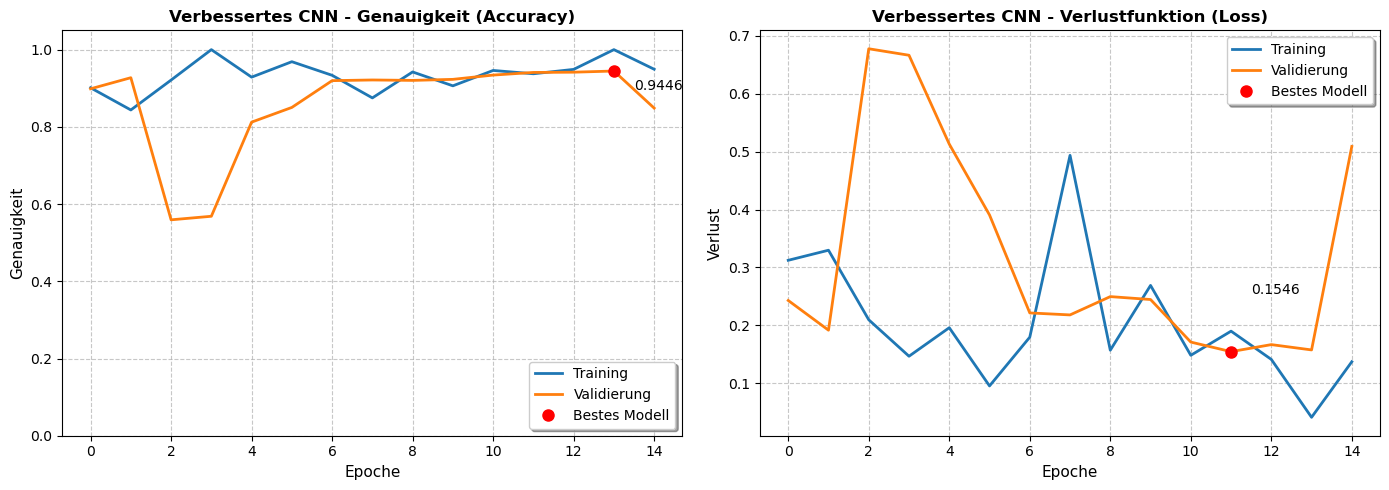

Modell-Metriken: ['loss', 'compile_metrics']
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9355 - loss: 0.1689 - weighted_accuracy: 0.9355
loss: 0.1407
compile_metrics: 0.9508
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
CM in der Funktion: [[2630  190]
 [ 120 3360]]


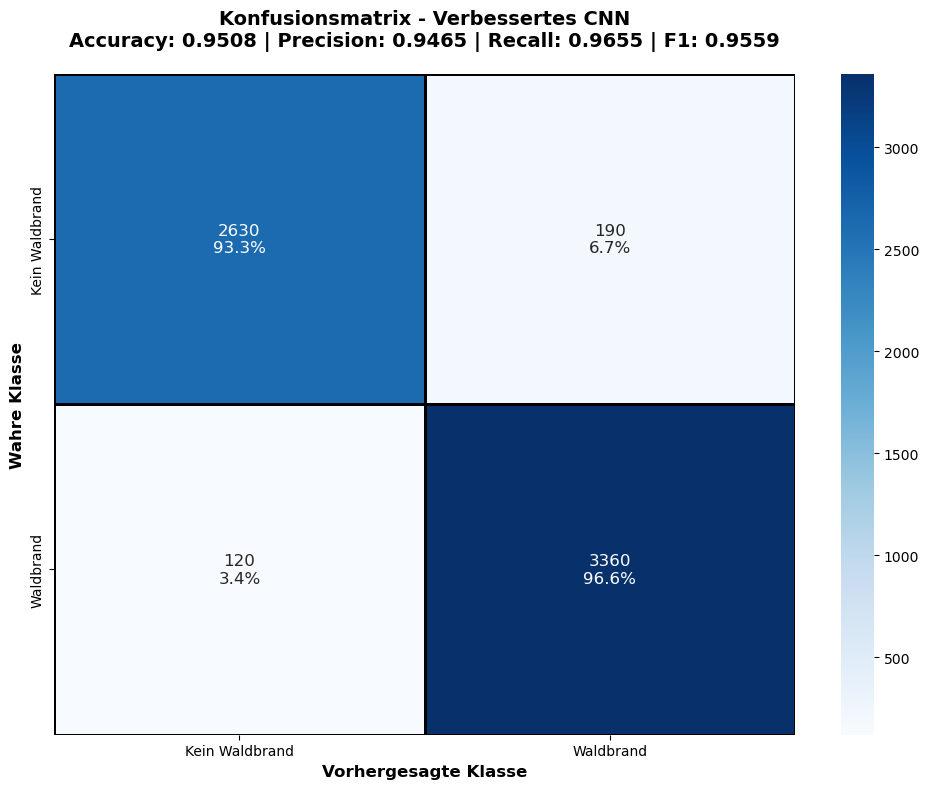


Klassifikationsmetriken:
Accuracy: 0.9508
Precision: 0.9465
Recall: 0.9655
F1-Score: 0.9559


In [74]:
def plot_history(history, title, figsize=(14, 5)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], linewidth=2)
    plt.plot(history.history['val_accuracy'], linewidth=2)

    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_val_acc_epoch]
    plt.plot(best_val_acc_epoch, best_val_acc, 'ro', markersize=8)
    plt.annotate(f'{best_val_acc:.4f}',
                 xy=(best_val_acc_epoch, best_val_acc),
                 xytext=(best_val_acc_epoch + 0.5, best_val_acc - 0.05),
                 fontsize=10)

    plt.title(f'{title} - Genauigkeit (Accuracy)', fontsize=12, fontweight='bold')
    plt.ylabel('Genauigkeit', fontsize=11)
    plt.xlabel('Epoche', fontsize=11)
    plt.ylim([0, 1.05])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(['Training', 'Validierung', 'Bestes Modell'], loc='lower right', frameon=True, fancybox=True, shadow=True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], linewidth=2)
    plt.plot(history.history['val_loss'], linewidth=2)

    best_val_loss_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_val_loss_epoch]
    plt.plot(best_val_loss_epoch, best_val_loss, 'ro', markersize=8)
    plt.annotate(f'{best_val_loss:.4f}',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(best_val_loss_epoch + 0.5, best_val_loss + 0.1),
                 fontsize=10)

    plt.title(f'{title} - Verlustfunktion (Loss)', fontsize=12, fontweight='bold')
    plt.ylabel('Verlust', fontsize=11)
    plt.xlabel('Epoche', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(['Training', 'Validierung', 'Bestes Modell'], loc='upper right', frameon=True, fancybox=True, shadow=True)

    if 'lr' in history.history:
        plt.figure(figsize=(7, 3))
        plt.plot(history.history['lr'], linewidth=2)
        plt.title('Learning Rate Verlauf', fontsize=12, fontweight='bold')
        plt.ylabel('Learning Rate', fontsize=11)
        plt.xlabel('Epoche', fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.yscale('log')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test_cat):
    try:
        print("Modell-Metriken:", model.metrics_names)
        evaluation_results = model.evaluate(X_test, y_test_cat, verbose=1)

        results_dict = {}
        for i, metric_name in enumerate(model.metrics_names):
            results_dict[metric_name] = evaluation_results[i]
            print(f"{metric_name}: {evaluation_results[i]:.4f}")

        return results_dict

    except Exception as e:
        print(f"Fehler bei der Modellauswertung: {e}")
        loss = model.evaluate(X_test, y_test_cat, verbose=0)
        print(f"Loss: {loss:.4f}")
        return {'loss': loss}

def plot_confusion_matrix(y_true, y_pred, title="Konfusionsmatrix", figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred)
    print("CM in der Funktion:", cm)

    if cm.shape != (2, 2):
        print(f"WARNUNG: Konfusionsmatrix hat unerwartete Dimensionen: {cm.shape}")
        if cm.shape[0] > 2 or cm.shape[1] > 2:
            cm_new = np.zeros((2, 2))
            cm_new[0, 0] = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
            cm_new[0, 1] = cm[0, 1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
            cm_new[1, 0] = cm[1, 0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
            cm_new[1, 1] = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
            cm = cm_new
            print("Korrigierte Matrix:", cm)

    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100

    annot = np.zeros_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n{cm_perc[i, j]:.1f}%"

    plt.figure(figsize=figsize)

    ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                    linewidths=1, linecolor='black', annot_kws={"size": 12})

    plt.title(f'{title}\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Wahre Klasse', fontsize=12, fontweight='bold')
    plt.xlabel('Vorhergesagte Klasse', fontsize=12, fontweight='bold')

    ax.xaxis.set_ticklabels(['Kein Waldbrand', 'Waldbrand'], fontsize=10)
    ax.yaxis.set_ticklabels(['Kein Waldbrand', 'Waldbrand'], fontsize=10)

    plt.tight_layout()
    plt.show()

    print("\nKlassifikationsmetriken:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

def vorhersage_einzelbild(model, bild_pfad, img_width=64, img_height=64, threshold=0.5):
    try:
        bild = cv2.imread(bild_pfad)
        if bild is None:
            print(f"Fehler: Bild konnte nicht geladen werden - {bild_pfad}")
            return None, None

        bild_anzeige = cv2.cvtColor(bild, cv2.COLOR_BGR2RGB)
        bild = cv2.resize(bild, (img_width, img_height))
        bild = bild / 255.0
        bild = np.expand_dims(bild, axis=0)

        vorhersage = model.predict(bild, verbose=0)
        klasse_wahrscheinlichkeit = vorhersage[0][1]

        klasse_name = 'Waldbrand' if klasse_wahrscheinlichkeit > threshold else 'Kein Waldbrand'

        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(bild_anzeige)
        plt.title(f'Vorhersage: {klasse_name}', fontsize=12, fontweight='bold')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        waldbrand_conf = vorhersage[0][1] * 100
        kein_waldbrand_conf = vorhersage[0][0] * 100

        bars = plt.barh(['Waldbrand', 'Kein Waldbrand'],
                        [waldbrand_conf, kein_waldbrand_conf],
                        color=['crimson', 'forestgreen'])

        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%', ha='left', va='center', fontweight='bold')

        plt.xlim([0, 105])
        plt.title('Konfidenz (%)', fontsize=12, fontweight='bold')
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        plt.gca().set_facecolor('#ffeeee' if klasse_name == 'Waldbrand' else '#eeffee')

        plt.axvline(x=threshold*100, color='blue', linestyle='--', linewidth=2)
        plt.text(threshold*100 + 1, 0.5, f'Schwellenwert ({threshold*100:.0f}%)',
                 ha='left', va='center', color='blue', fontweight='bold')

        plt.tight_layout()
        plt.show()

        return klasse_name, klasse_wahrscheinlichkeit

    except Exception as e:
        print(f"Fehler bei der Bildvorhersage: {e}")
        return None, None

plot_history(custom_history, 'Verbessertes CNN')

eval_results = evaluate_model(custom_model, test_img, test_cat)

predictions = custom_model.predict(test_img)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_cat, axis=1)
plot_confusion_matrix(y_true, y_pred, title="Konfusionsmatrix - Verbessertes CNN")

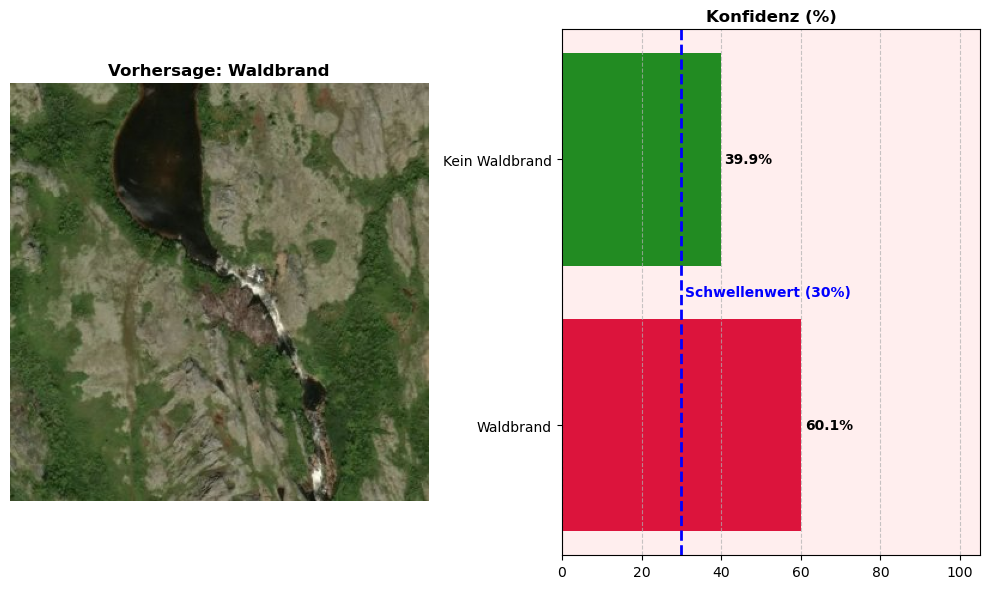

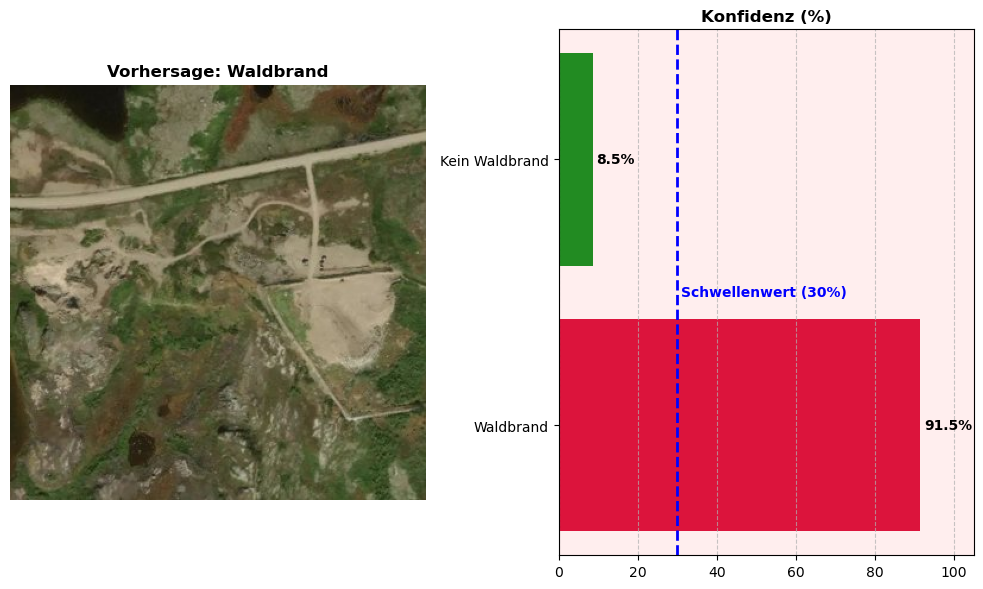

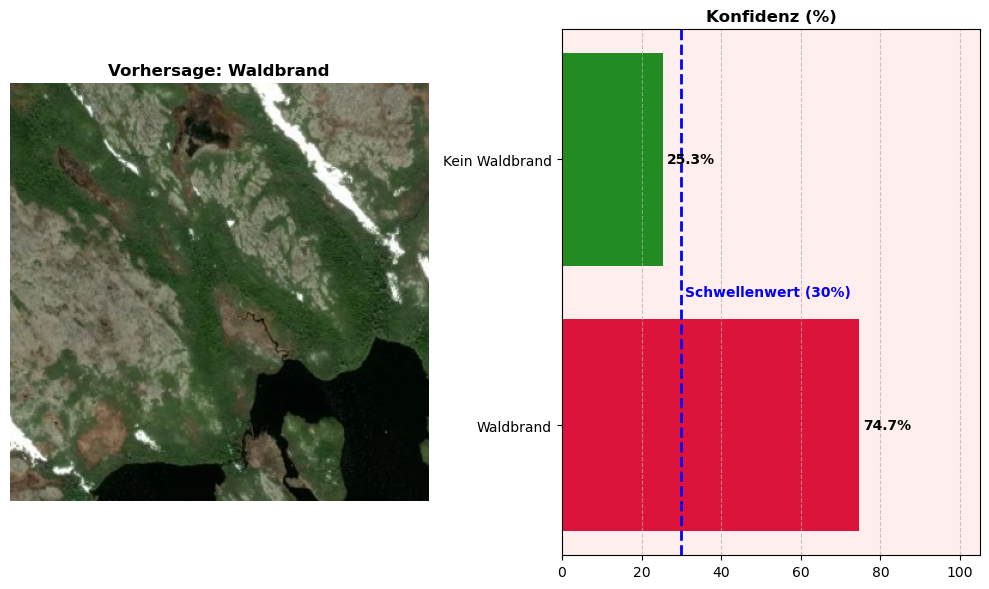

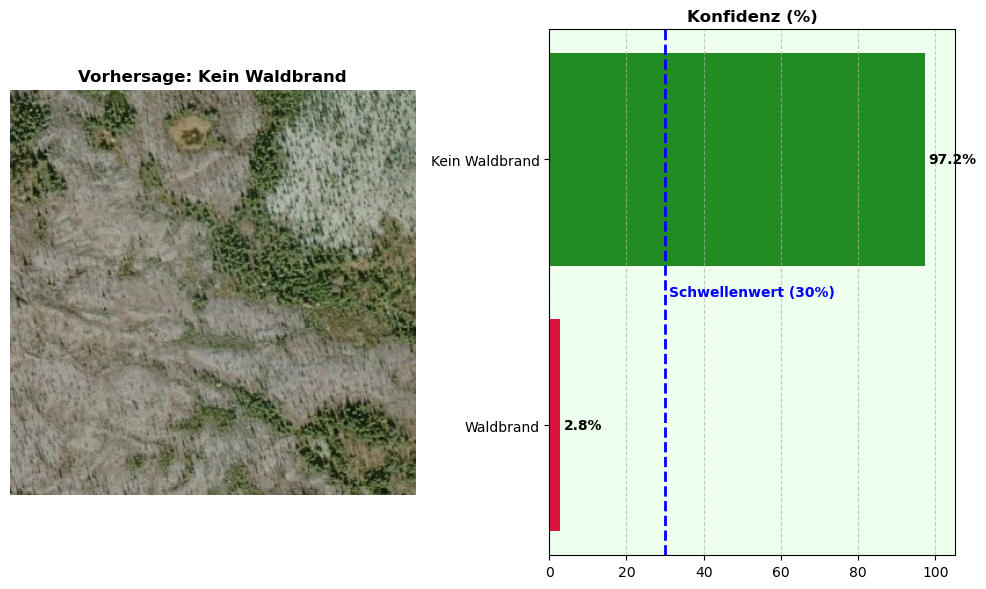

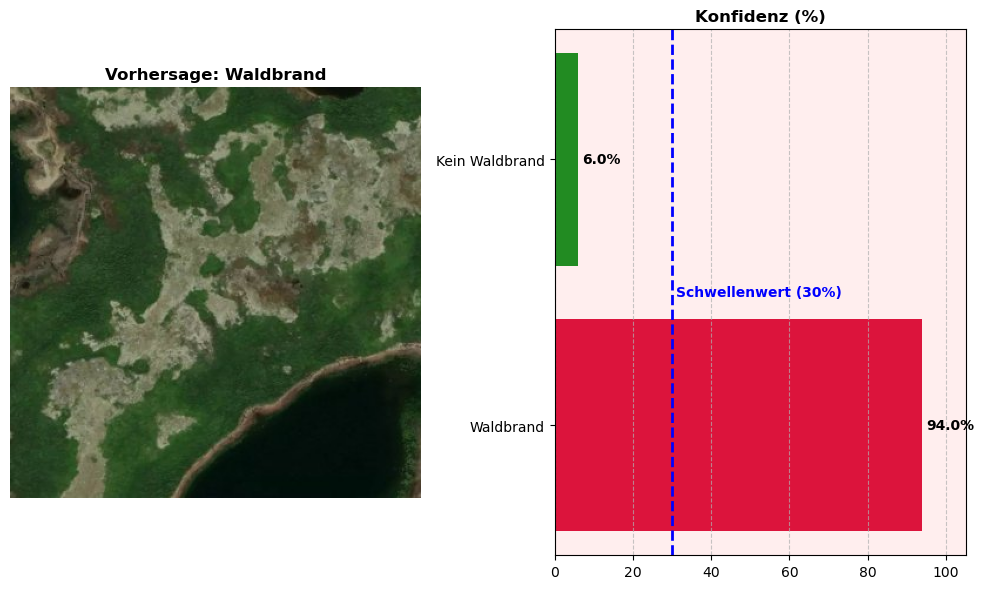

In [66]:
count = 0
folder = os.path.join(valid_path, "wildfire")
for img_name in os.listdir(folder):
    vorhersage_einzelbild(custom_model, os.path.join(folder, img_name), threshold=0.3)
    count += 1
    if(count == 5):
        break

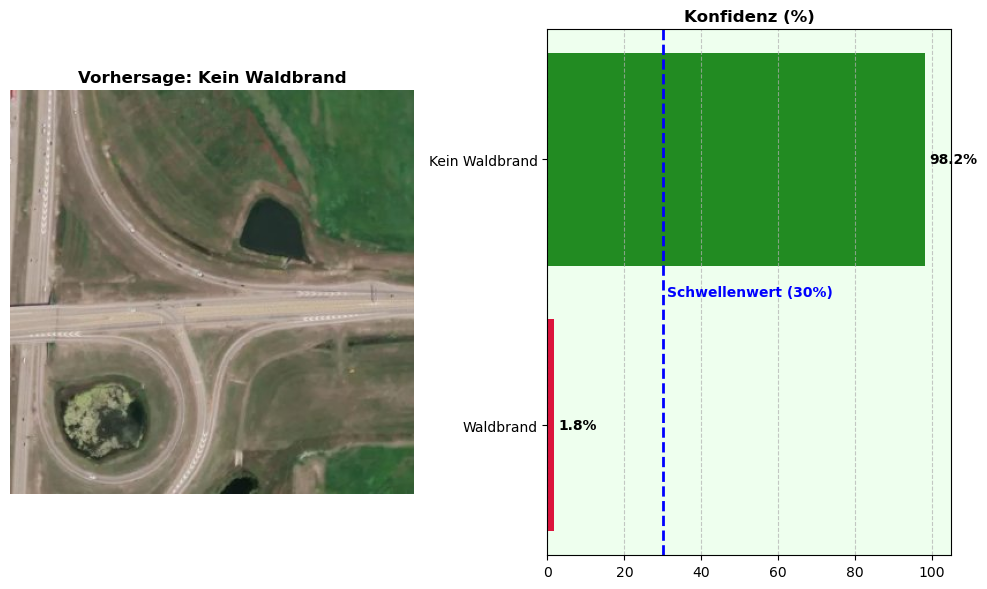

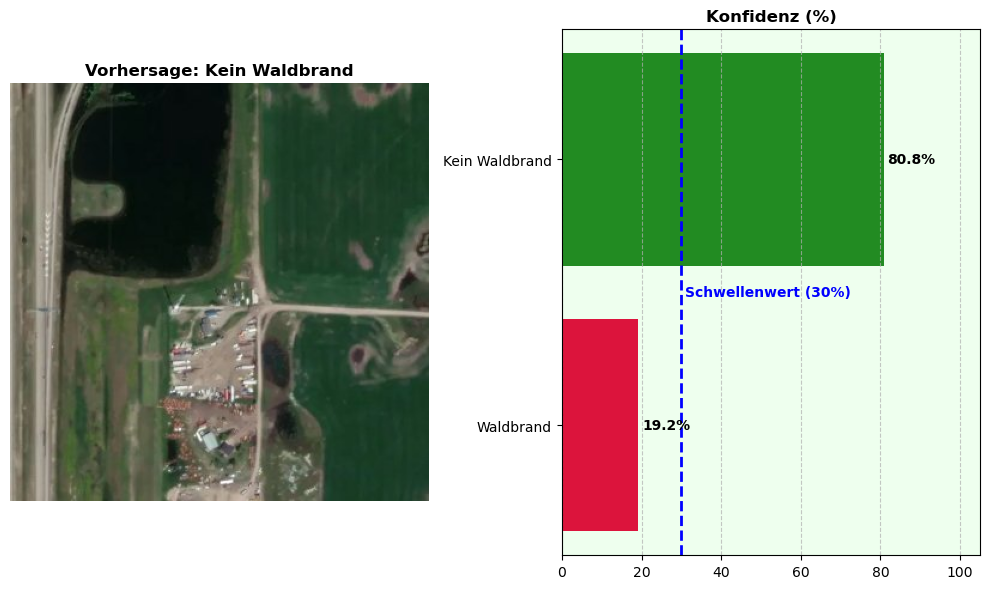

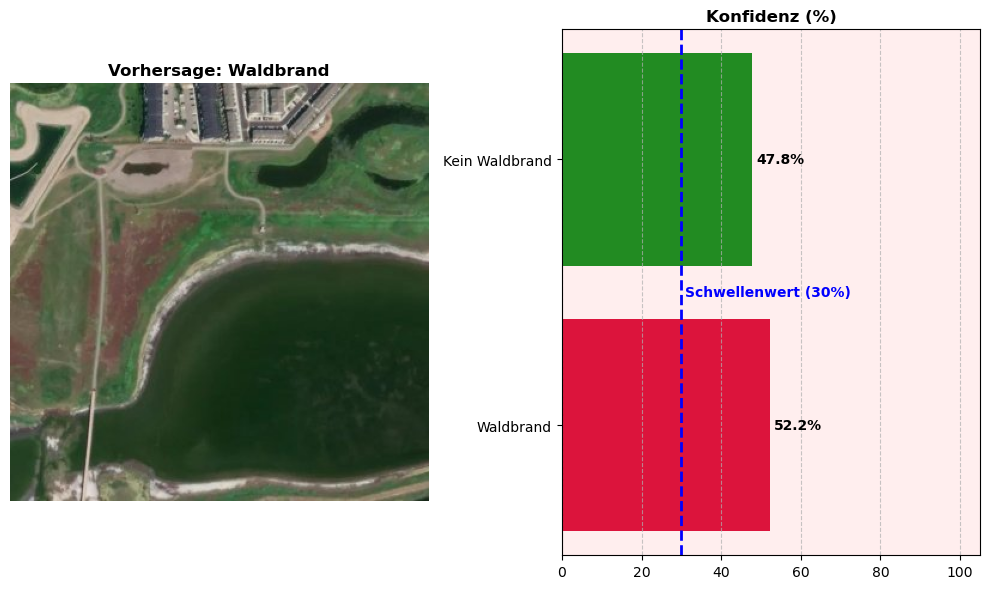

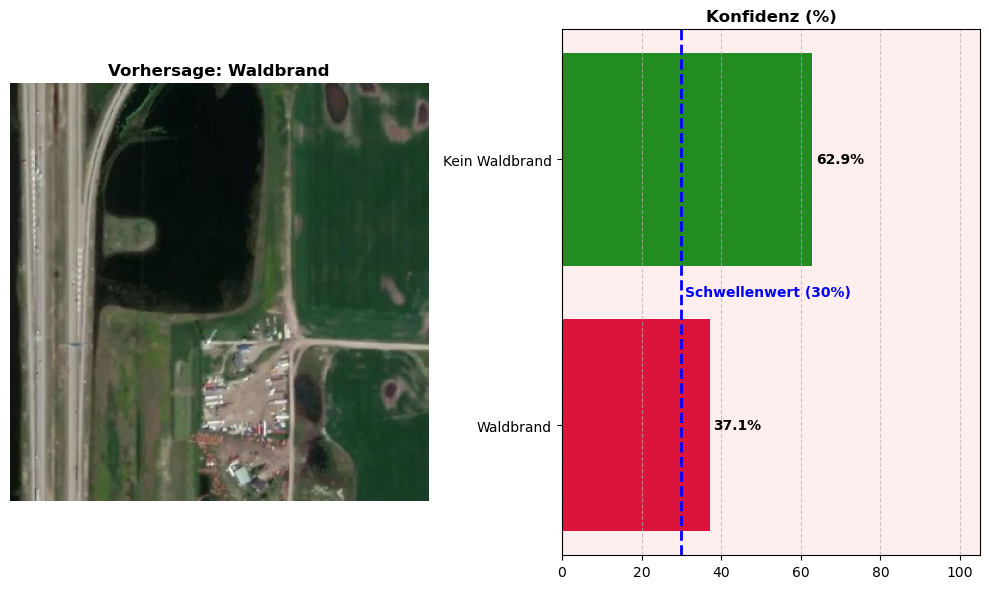

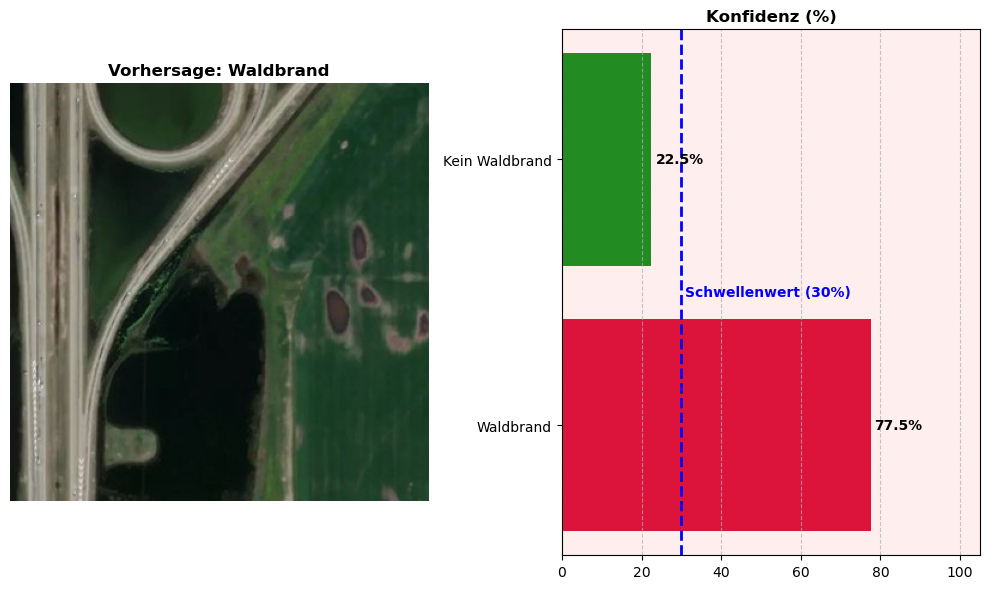

In [68]:
count = 0
folder = os.path.join(valid_path, "nowildfire")
for img_name in os.listdir(folder):
    vorhersage_einzelbild(custom_model, os.path.join(folder, img_name), threshold=0.3)
    count += 1
    if(count == 5):
        break

Model speichern

In [33]:
custom_model.save("custom_model.keras")